# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2023-24 учебный год

# Семинар 19. Полносвязная нейронная сеть

Полносвязанная нейронная сеть - пример многослойной сети, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне.  

Расмотрим их устройство более подробно:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

**Важно!** Cвязи есть у нейронов слоя $n_{i-1}$  и нейронов слоя $n_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** - это матрица $(n, m)$.

При решении ***задачи регрессии*** на выходном слое обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на выходном слое обычно один нейрон, если задача бинарной классификации, и $N$ нейронов, если задача $N$-класовой классификации.

Для построения нейронной сети необходимо определиться со следующими компонентами:

- **архитектура** нейросети (количество и тип слоев, функции активации между слоями);
- **инициализация** весов каждого слоя;
- метод **оптимизации** (SGD, Adam и т.д.);
- размер **батчей** (сколько примеров на вход);
- количетсво **эпох** обучения;
- **функция потерь**;  
- тип **регуляризации** нейросети (штрафы за ошибки)

## Классификация рукописных цифр

Итак, перед нами стоит задача классифицировать с помощью полносвязанной сети датасет MNIST. Он представляет собой набор цифрр от 0 до 9, написанные от руки. Каждая картинка имеет размер 28 на 28 пикселей и является черно-белой.

Поскольку мы начинаем увлекательное путешествие в мир глубокого обучения и нейронный сетей, мы будем его исследовать, а значит ставить эксперименты. Для удобного отслеживания всех метрик, значений градиентов и прочего мы будем использовать очень удобный сервис [Wandb](https://wandb.ai/site).

Пройдите по ссылке и зарегистрируйтесь в нем.

<center><img src = "https://i.imgur.com/1sm6x8P.png" width = "750" height = "500"/></center>  

**Weights & Biases** - это платформа машинного обучения для разработчиков.

Вы можете использовать W&B, чтобы

- следить за обучением онлайн
- отслеживать версии и итераций модели
- оценивать производительность моделей
- воспроизводить модели
- визуализировать результаты
- делиться результатами с коллегами

In [1]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

Перед началом работы настоятельно рекомендуется зафиксировать сиды (для воспроизводимости результатов). Последние 2 строки нам пригодятся на следующем занятии.

In [3]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Также очень удобно все переменные (размер батча, количество эпох и прочее) сразу определить через класс конфигурации, чтобы потом не искать в коде, где они применяются, а поменять всего один раз в классе.

In [4]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "4bc1ab80ba6cc5cf38f824b647f74e0e95f3f2c6"# вписать свой API Wandb
  project = "test-project"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "ekteam"# ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  wandb = True # флаг использования Wandb

In [5]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

### Загрузка данных и их анализ

Загрузим наши данные.

In [6]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

Для загрузи будем использовать встроенный метод Dataloader. Чем он хорош? Он загружает наши данные в память GPU строго по батчам, храня остальные на CPU, тем самым позволяя экономить драгоценную видеопамять.

In [7]:
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2884110.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 500151.50it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4161403.99it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8799320.45it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным

In [9]:
example_data.shape # проверим размерность

torch.Size([512, 1, 28, 28])

### EDA данных

Посмотрим, что представляют собой наши данные.

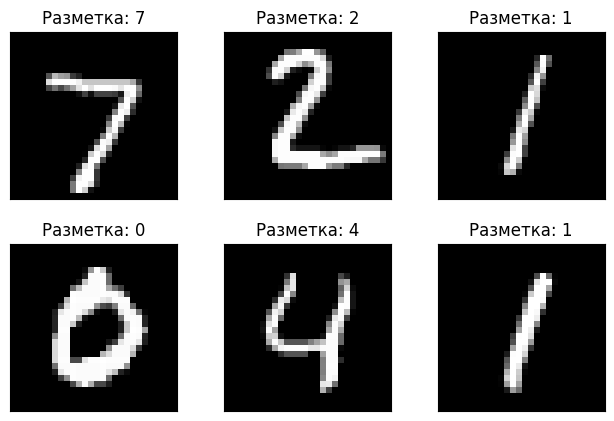

In [10]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1) # отрисуем 12 картинок
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Разметка: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig;

Ага, видим, что у каждой картинки есть своя метка, которую мы будем использовать при обучении.

Посмотрим на одну картинку более детально.

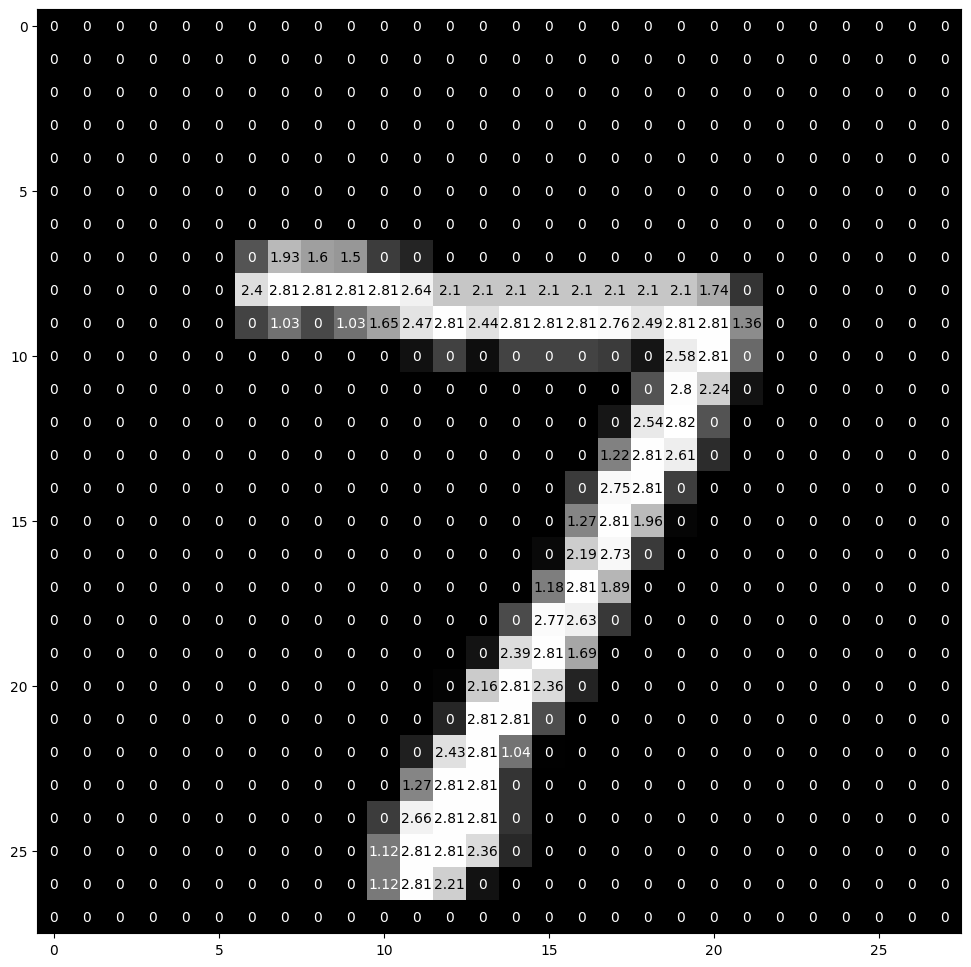

In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5 # установим порог
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] > 1 else 0 # округлим значения пикселей до двух знаков
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Строим полносвязанную нейронную сеть

Построение нейронной сети в PyTorch одно удовольствие. Этот процесс напоминает построение детской пирамидки: нанизывание одного элемента за другим, причем каждый элемент строго на своем месте.

Все функции активации, потерь и элементарные блоки уже реализованы в PyTorch.

Например, один полносвязанный слой вызывается методом **nn.Linear**, которому передается количество нейронов на вход и на выход.

In [12]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net,self).__init__()
        # количество нейронов в скрытых слоях (256, 128)
        hidden_1 = 256
        hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1)
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(hidden_2,10)

    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1,28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = self.fc3(x)
        return x

Определяем модель

In [13]:
model = MNIST_Net()
model = model.cuda() # переводим модель на GPU
print(model) # посмотрим на нашу модель

MNIST_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Определяем функцию потерь и оптимизатор

In [14]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [15]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [16]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [17]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available() # проверяем доступность GPU

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device("cuda" if use_cuda else "cpu") # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

Перед началом обучения обязательно проверяем состояние нашей видеокарты.

In [18]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Jun 10 18:19:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              29W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Учим!

In [19]:
CFG.wandb

True

In [20]:
main(model)

wandb: Currently logged in as: mogilnikoff2 (ekteam). Use `wandb login --relogin` to force relogin



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:18<00:00, 49.79it/s]



Train set: Average loss: 0.5128, Accuracy: 80%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set: Average loss: 0.5744, Accuracy: 90%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.97it/s]


Train set: Average loss: 0.2135, Accuracy: 91%


Test set: Average loss: 0.4659, Accuracy: 92%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 55.29it/s]


Train set: Average loss: 0.1763, Accuracy: 93%


Test set: Average loss: 0.4154, Accuracy: 93%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 53.55it/s]



Train set: Average loss: 0.4172, Accuracy: 94%
Test set: Average loss: 0.3652, Accuracy: 94%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 52.84it/s]


Train set: Average loss: 0.0784, Accuracy: 95%


Test set: Average loss: 0.3261, Accuracy: 95%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 55.21it/s]



Train set: Average loss: 0.1469, Accuracy: 95%
Test set: Average loss: 0.2997, Accuracy: 96%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 52.84it/s]


Train set: Average loss: 0.0913, Accuracy: 96%


Test set: Average loss: 0.2721, Accuracy: 96%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 54.52it/s]


Train set: Average loss: 0.0473, Accuracy: 96%


Test set: Average loss: 0.2634, Accuracy: 96%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.72it/s]


Train set: Average loss: 0.0427, Accuracy: 97%


Test set: Average loss: 0.2364, Accuracy: 96%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 53.83it/s]


Train set: Average loss: 0.3745, Accuracy: 97%


Test set: Average loss: 0.2242, Accuracy: 97%
Training is end!


Видим, что обучение идет: функция потерь падает, метрика растет.

А что если взять более продвинутый оптимизатор?

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [22]:
main(model)

test_accuracy,▁▃▅▆▆▇▇███
test_loss,█▆▅▄▃▃▂▂▁▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▇▂▃▂▁▁▆
test_accuracy,0.9666
test_loss,0.22424
train_accuracy,0.97053
train_loss,0.3745



Epoch: 1


100%|██████████| 938/938 [00:18<00:00, 51.32it/s]


Train set: Average loss: 0.1271, Accuracy: 96%


Test set: Average loss: 0.1845, Accuracy: 97%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.94it/s]


Train set: Average loss: 0.1108, Accuracy: 97%


Test set: Average loss: 0.1079, Accuracy: 97%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.45it/s]


Train set: Average loss: 0.0732, Accuracy: 98%


Test set: Average loss: 0.1773, Accuracy: 97%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 52.80it/s]


Train set: Average loss: 0.0033, Accuracy: 99%


Test set: Average loss: 0.1218, Accuracy: 98%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 53.10it/s]


Train set: Average loss: 0.0061, Accuracy: 99%


Test set: Average loss: 0.0883, Accuracy: 98%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 51.82it/s]


Train set: Average loss: 0.0167, Accuracy: 99%


Test set: Average loss: 0.1375, Accuracy: 98%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 52.63it/s]


Train set: Average loss: 0.0198, Accuracy: 99%


Test set: Average loss: 0.1602, Accuracy: 98%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 53.03it/s]


Train set: Average loss: 0.0737, Accuracy: 99%


Test set: Average loss: 0.1403, Accuracy: 98%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.47it/s]


Train set: Average loss: 0.0028, Accuracy: 99%


Test set: Average loss: 0.2104, Accuracy: 98%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 53.93it/s]


Train set: Average loss: 0.1850, Accuracy: 99%


Test set: Average loss: 0.1464, Accuracy: 98%
Training is end!


Сразу видим, что обучение пошло гораздо быстрее и значение метрики выше. Не обманула математика!

В PyTorch полносвязанную сеть можно создать с помощью готового метода Sequential(). По сути это уже готовый каркас, куда можно вставить слои и активации, в итоге нам не нужно в forward прописывать каждый слой отдельно, все работает в автоматическом режиме. Красота!

In [23]:
class MNIST_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super(MNIST_Net,self).__init__()
        # организуем 3 скрытых слоя
        hidden_1 = 512
        hidden_2 = 256
        hidden_3 = 128
        #
        self.net = torch.nn.Sequential(
                      torch.nn.Linear(28*28, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_3, 10),
                      torch.nn.Softmax()
                    )

    def forward(self,x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1,28*28)
        x = self.net(x)
        return x

In [24]:
model = MNIST_Net()
model = model.cuda() # переводим модель GPU
print(model) # посмотрим на нашу модель

MNIST_Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)


In [25]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

Проверим, что все работает.

In [26]:
main(model)

test_accuracy,▁▄▃▆▆▆▇▇█▆
test_loss,▇▂▆▃▁▄▅▄█▄
train_accuracy,▁▄▅▆▇▇▇███
train_loss,▆▅▄▁▁▂▂▄▁█
test_accuracy,0.976
test_loss,0.14636
train_accuracy,0.99395
train_loss,0.18503



Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 938/938 [00:18<00:00, 50.74it/s]


Train set: Average loss: 1.4918, Accuracy: 83%


Test set: Average loss: 1.5751, Accuracy: 94%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 51.33it/s]


Train set: Average loss: 1.5542, Accuracy: 94%


Test set: Average loss: 1.5570, Accuracy: 94%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 53.12it/s]


Train set: Average loss: 1.5135, Accuracy: 95%


Test set: Average loss: 1.5382, Accuracy: 96%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 52.32it/s]


Train set: Average loss: 1.5558, Accuracy: 95%


Test set: Average loss: 1.5529, Accuracy: 95%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.71it/s]


Train set: Average loss: 1.5549, Accuracy: 95%


Test set: Average loss: 1.5483, Accuracy: 95%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 54.44it/s]


Train set: Average loss: 1.5319, Accuracy: 96%


Test set: Average loss: 1.5704, Accuracy: 95%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 54.39it/s]


Train set: Average loss: 1.5509, Accuracy: 95%


Test set: Average loss: 1.5853, Accuracy: 95%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 53.69it/s]


Train set: Average loss: 1.4924, Accuracy: 95%


Test set: Average loss: 1.5752, Accuracy: 93%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 53.84it/s]


Train set: Average loss: 1.4923, Accuracy: 95%


Test set: Average loss: 1.5790, Accuracy: 95%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 54.06it/s]


Train set: Average loss: 1.5725, Accuracy: 95%


Test set: Average loss: 1.5383, Accuracy: 96%
Training is end!


Итак, мы наглядно показали - даже небольшая полносвязанная сеть способна уже решать нетривиалные задачи и решать их крайне успешно.